In [25]:
"""

This Jupyter Notebook implements the following using OPENCV Transformations and Sliding Window Search:

(1) Computes the camera calibration matrix and distortion coefficients given a set of chessboard images.
(2) Applies a distortion correction to raw images.
(3) Uses color transforms, gradients, etc., to create a thresholded binary image.
(4) Applies a perspective transform to rectify binary image ("birds-eye view").
(5) Detects lane pixels and fit to find the lane boundary.
(6) Determines the curvature of the lane and vehicle position with respect to center.
(7) Warps the detected lane boundaries back onto the original image.
(8) Outputs visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

"""
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import math
import os
%matplotlib inline

# Global variables
FIMAGES = glob.glob('./camera_cal/calibration*.jpg')
TESTIMAGES = ['./test_images/' + x for x in os.listdir('./test_images/')]
SRC = np.array([[578, 460], [704, 460], [1070, 686], [240, 686]], dtype=np.float32)
DST = np.array([[240, 0], [1070, 0], [1070, 720], [240, 720]], dtype=np.float32)

In [2]:
def getImages(fnames):
    """
    
    This function imports images from a list of files
    
    Args:
          fnames(str): An array containing the path of the images
    Return:
          images(uint8): An array of all images specified in fnames
    
    """
    images = []
    titles = []
    for file in fnames:
        titles.append(file.split('/')[-1])
        images.append(mpimg.imread(file))
    return images, titles

def display(images, m=20, n=14, k=4, titles=None, axis='off', cmap=None):
    """
    
    This function takes a array of images as an input and displays the images in a window
    
    Args:
            (1) images(uint8): An array of image paths to display
            (2) m, n (int): Dimensions of displays window
    Returns:   
            (1) A window displaying all images
    
    """
    n_imgs = len(images)
    plt.figure(figsize = (m, n))
    for i,img in enumerate(images):
        plt.subplot(math.ceil(n_imgs/k), k, i+1)
        plt.imshow(img, cmap=cmap)
        if(titles == None):
            plt.title(i)
        else:
            plt.title(titles[i])
        plt.axis(axis)
    plt.show()

def findCorners(image, m=9, n=6):
    """
    
    This function takes an array of images as an input, finds the Chessboard Corners and returns an array of 
    images with the Chessboard corners drawn
    
    Args:
            (1) image(uint8): An 8 bit image
    Returns:
            (1) dotimage(uint8): Image with the Chessboard corners drawn
            
    """
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....., (6,5,0)
    objp = np.zeros((m*n,3), np.float32)
    objp[:,:2] = np.mgrid[0:m,0:n].T.reshape(-1,2)
    
    # Define empty arrays to store the object points and image points from all images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane
    dotimage = image.copy()
    
    # Step through the images and search for ChessBoard Corners
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
    # Find the ChessBoard Corners
    ret, corners = cv2.findChessboardCorners(gray, (m,n), flags=cv2.CALIB_CB_ADAPTIVE_THRESH)
        
    # If found store the object points and image points
    if(ret == True):
        objpoints.append(objp)
        imgpoints.append(corners)
            
        # Draw the corners
        dotimage = cv2.drawChessboardCorners(dotimage, (m,n), corners, ret)
        
    return dotimage, objpoints, imgpoints
    
def calibrate(img, objp, imgp):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objp, imgp, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs

def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

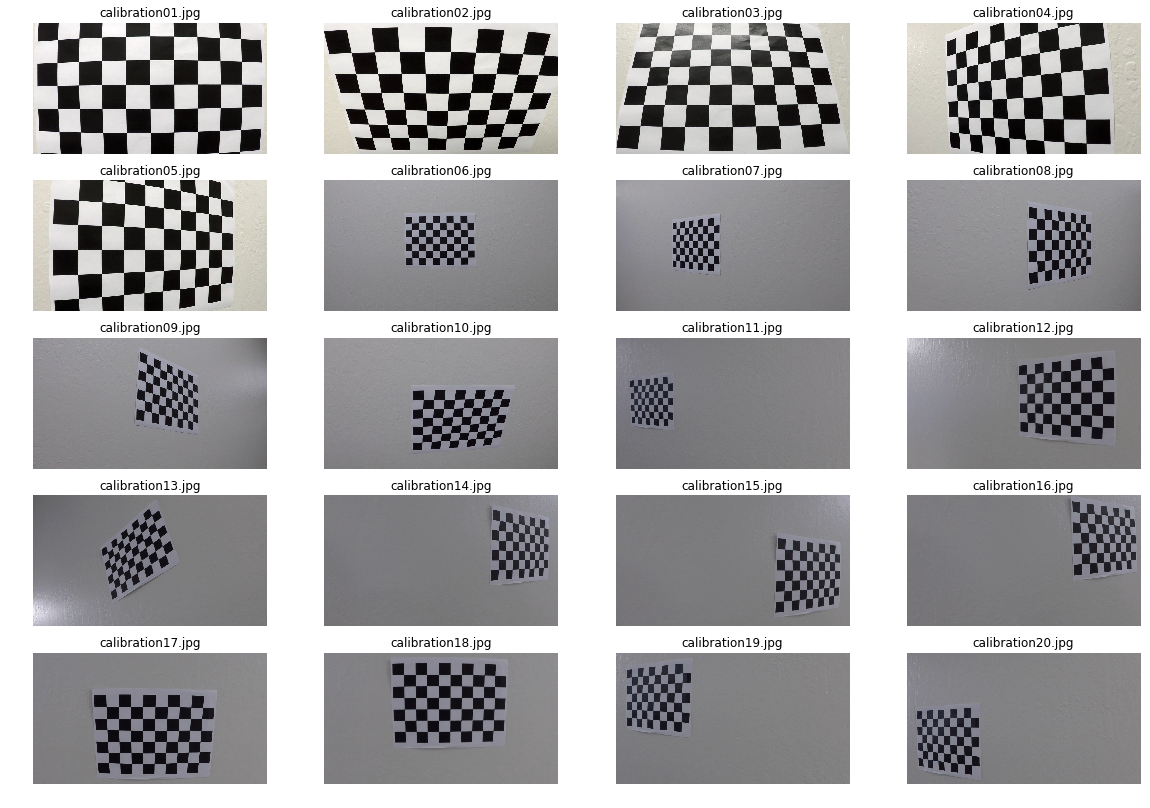

In [3]:
def showChessBoardImages():
    chessimg, titles = getImages(FIMAGES)
    display(chessimg, titles=titles)
    
if __name__=="__main__":
    showChessBoardImages()

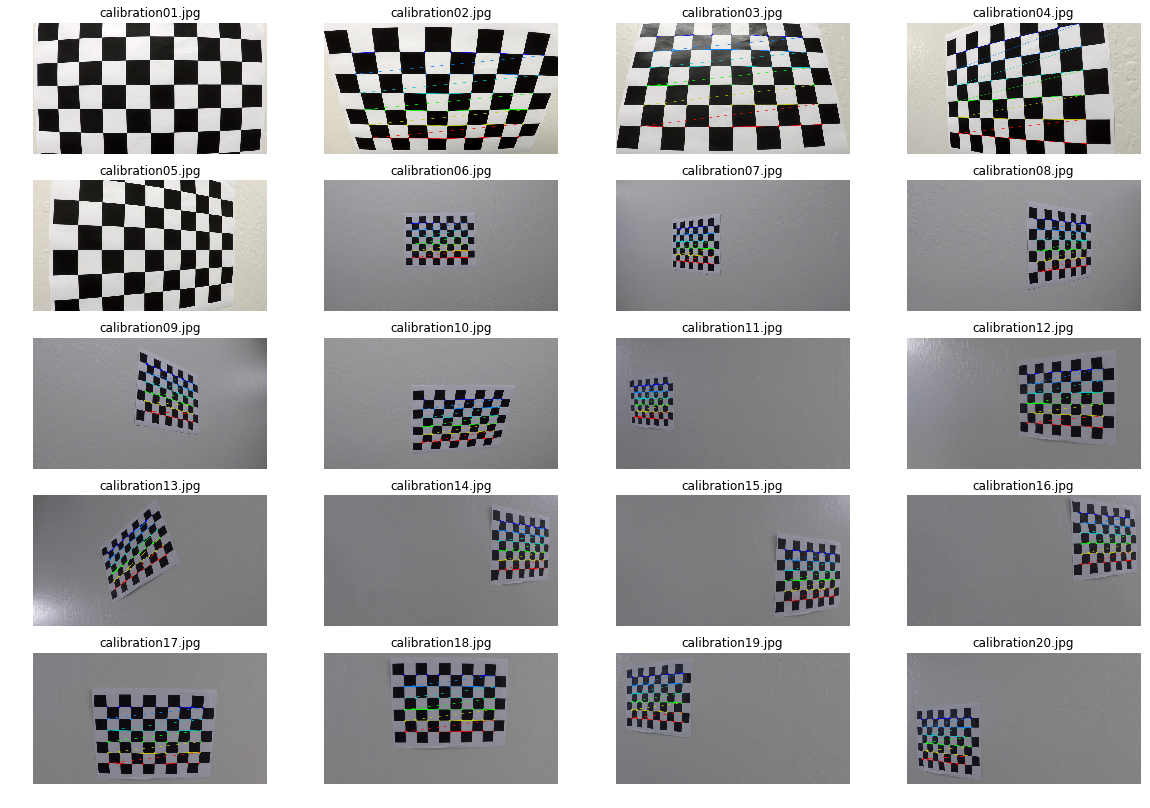

In [4]:
def showChessBoardCorners():
    chessimages, titles = getImages(FIMAGES)
    chessdots = []
    dottitles = []
    objpoints = []
    imagepoints = []
    for i, img in enumerate(chessimages):
        dotimg, objp, imgp = findCorners(img)
        chessdots.append(dotimg)
        objpoints.append(objp)
        imagepoints.append(imgp)
        dottitles.append(titles[i])

    display(chessdots, titles=dottitles)

if __name__=="__main__":
    showChessBoardCorners()

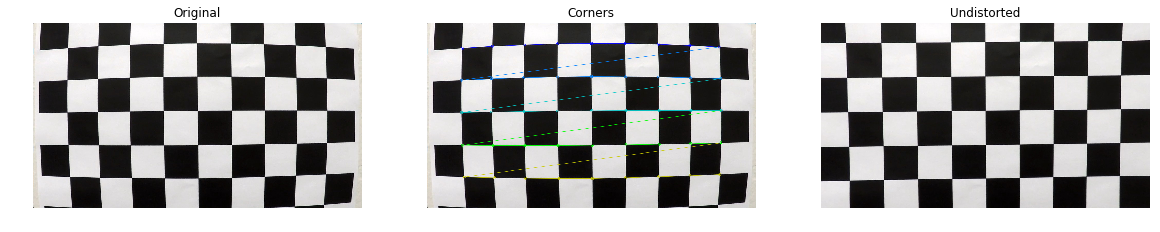

In [5]:
def calibrateCameraDistortion():
    chessimages, titles = getImages(FIMAGES)
    img = chessimages[0]
    dotimg, objp, imgp = findCorners(img, m=9, n=5)
    ret, mtx, dist, rvecs, tvecs = calibrate(img, objp, imgp)
    dst = undistort(img, mtx=mtx, dist=dist)
    display([img, dotimg, dst], k=3, titles=['Original', 'Corners', 'Undistorted'])
    return ret, mtx, dist, rvecs, tvecs

if __name__=="__main__":
    RET, MTX, DIST, RVECS, TVECS = calibrateCameraDistortion()

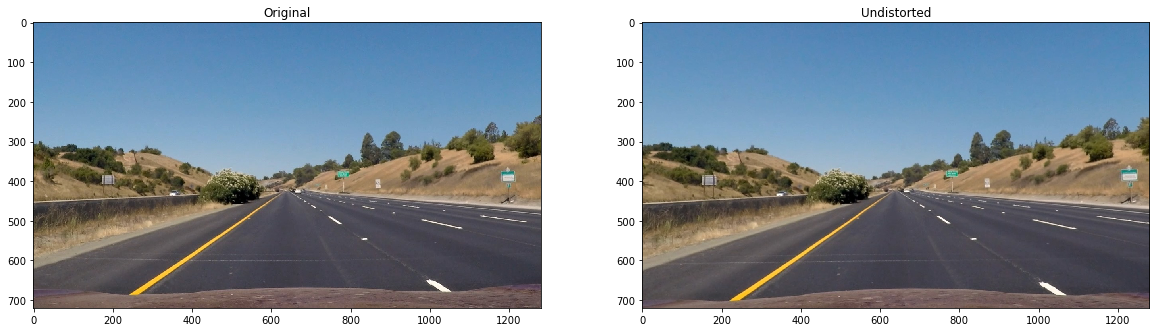

In [6]:
def undistortTestImages():
    path = TESTIMAGES[0]
    img = mpimg.imread(path)
    dst = undistort(img, mtx=MTX, dist=DIST)
    display([img, dst], k=2, titles=['Original', 'Undistorted'], axis='on')
    
if __name__=="__main__":
    undistortTestImages()

In [43]:
def absGradientThreshold(img, orient='x', k_size=3, grad_thresh=(20,100)):
    
    assert(orient == 'x' or orient == 'y' or orient == 'xy'), "Invalid Orientation: Choose 'x', 'y' or 'xy'"
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=k_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=k_size)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    sxbinary = np.zeros_like(scaled_sobelx)
    sybinary = np.zeros_like(scaled_sobely)
    
    sxbinary[(scaled_sobelx > grad_thresh[0]) & (scaled_sobelx <= grad_thresh[1])] = 1
    sybinary[(scaled_sobely > grad_thresh[0]) & (scaled_sobely <= grad_thresh[1])] = 1
    
    if(orient == 'x'):
        binary_output = sxbinary
    elif(orient == 'y'):
        binary_output = sybinary
    elif(orient == 'xy'):
        binary_output = sxbinary | sybinary
    else:
        raise ValueError("Invalid Orientation: Choose 'x', 'y' or 'xy'")
        
    return binary_output

def absMagnitudeThreshold(img, k_size=3, mag_thresh=(20,100)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=k_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=k_size)
    
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    
    magbinary = np.zeros_like(scaled_sobel)
    magbinary[(scaled_sobel > mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    binary_output = magbinary
    
    return binary_output

def absDirectionThreshold(img, k_size=3, dir_thresh=(0,np.pi/2)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=k_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=k_size)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)
    
    dirbinary = np.zeros_like(dir_sobel)
    dirbinary[(dir_sobel > dir_thresh[0]) & (dir_sobel <= dir_thresh[1])] = 1
    
    binary_output = dirbinary
    
    return binary_output

def combinedGradientThreshold(img, k_size=3, grad_thresh=(20,100), mag_thresh=(20,100), dir_thresh=(0,np.pi/2)):
    
    gradx = absGradientThreshold(img, orient='x', k_size=k_size, grad_thresh=grad_thresh)
    #grady = absGradientThreshold(img, orient='y', k_size=k_size, grad_thresh=grad_thresh)
    mag_binary = absMagnitudeThreshold(img, k_size=k_size, mag_thresh=mag_thresh)
    dir_binary = absDirectionThreshold(img, k_size=k_size, dir_thresh=dir_thresh)
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

def colorThreshold(img, color_thresh=(170,255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > color_thresh[0]) & (s_channel <= color_thresh[1])] = 1
    
    return s_binary

def combinedColorGradientThreshold(img, orient='x', k_size=3, color_thresh=(170,255), grad_thresh=(20,100)):
    
    s_binary = colorThreshold(img, color_thresh=color_thresh)
    
    sxbinary = absGradientThreshold(img, orient=orient, k_size=k_size, grad_thresh=grad_thresh)
    
    color_binary = (np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255.999).astype(np.uint8)
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary, color_binary

def perspectiveTransform(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M

def drawPolyLines(img, points, imgtype = 'rgb'):
    points = np.array(points, np.int32)
    points = points.reshape((-1,1,2))
    
    if(imgtype == 'binary'):
        img = (np.dstack((img, img, img)) * 255.999).astype(np.uint8)
        
    img = cv2.polylines(img,[points],True,(255,0,0), 2)
    return img

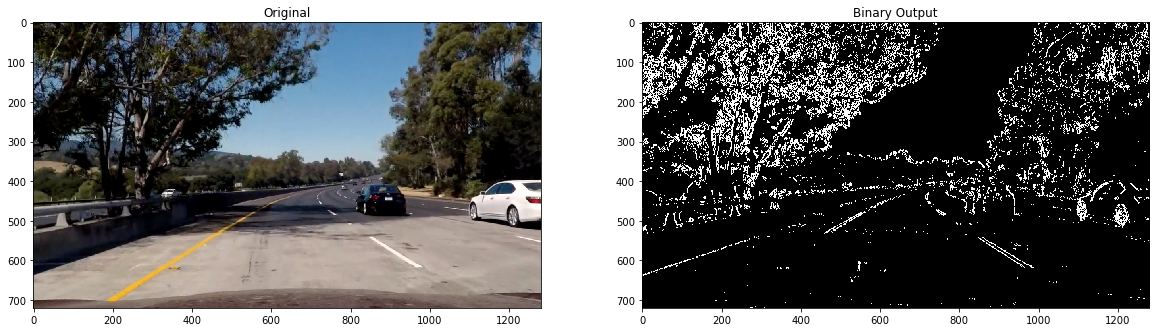

In [8]:
def showGradientBinaryOutput():
    path = TESTIMAGES[6]
    img = mpimg.imread(path)
    img = undistort(img, mtx=MTX, dist=DIST)
    binary_output = combinedGradientThreshold(img, grad_thresh=(25, 150), mag_thresh=(25, 150), \
                                              dir_thresh=(0.7, 1.3))
    display([img, binary_output], k=2, titles=['Original', 'Binary Output'], axis='on', cmap='gray')

if __name__=="__main__":
    showGradientBinaryOutput()

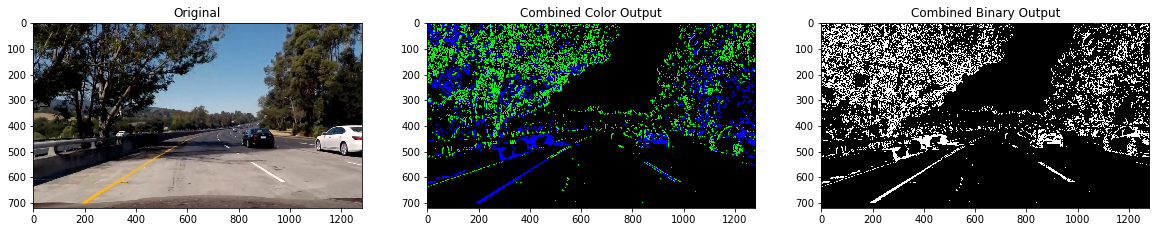

In [9]:
def showColorGradientBinary():
    path = TESTIMAGES[6]
    img = mpimg.imread(path)
    img = undistort(img, mtx=MTX, dist=DIST)
    combined, color = combinedColorGradientThreshold(img)
    display([img, color, combined], k=3, titles=['Original','Combined Color Output', 'Combined Binary Output'], \
            axis='on', cmap = 'gray')
    return combined

if __name__=="__main__":
    showColorGradientBinary()

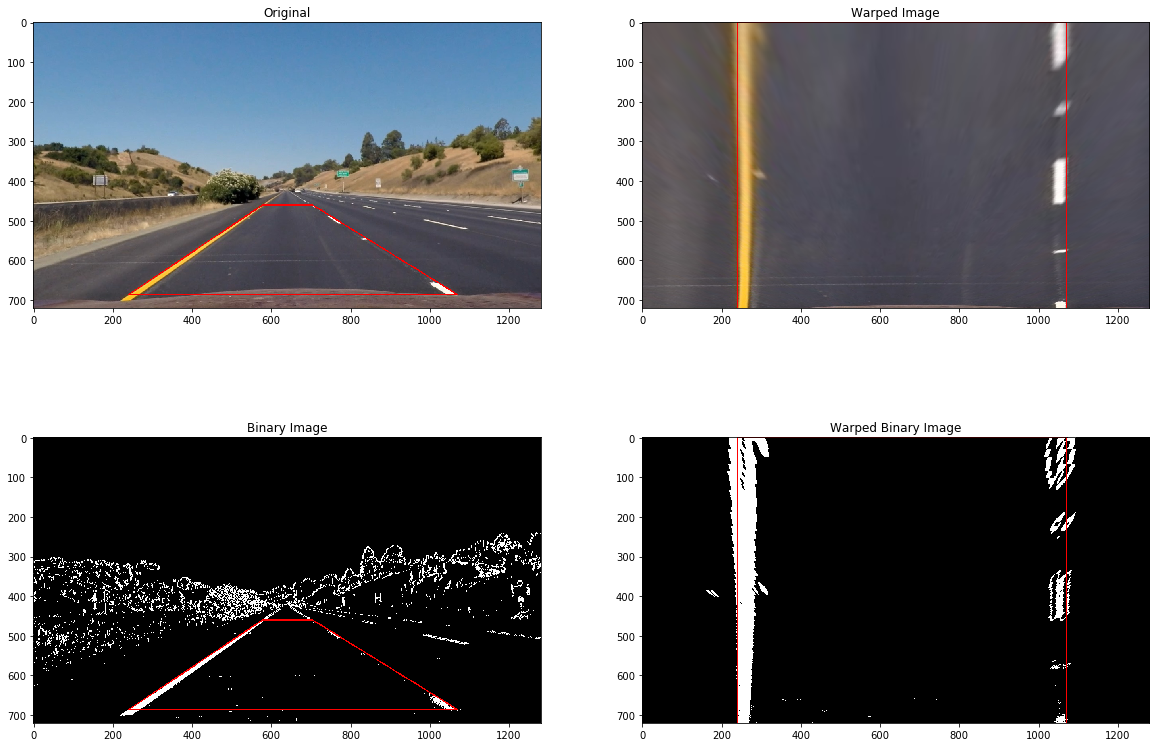

In [44]:
def showPerspectiveTransform():
    path = TESTIMAGES[0]
    img = mpimg.imread(path)
    img = undistort(img, mtx=MTX, dist=DIST)
    combined_binary, _ = combinedColorGradientThreshold(img)
    warped_image, M_image = perspectiveTransform(img, SRC, DST)
    warped_binary, M_binary = perspectiveTransform(combined_binary, SRC, DST)
    img = drawPolyLines(img, SRC)
    warped_image = drawPolyLines(warped_image, DST)
    combined_binary = drawPolyLines(combined_binary, SRC, imgtype='binary')
    warped_binary = drawPolyLines(warped_binary, DST, imgtype='binary')
    display([img, warped_image, combined_binary, warped_binary], k=2, \
            titles=['Original', 'Warped Image', 'Binary Image', 'Warped Binary Image' ], axis='on', cmap='gray')
                                                                                
if __name__=="__main__":
    showPerspectiveTransform()

In [47]:
def histogram(img):
    return np.sum(img[img.shape[0]//2:,:], axis=0)

def sliding_window(img):
    

In [ ]:
class Line():
    

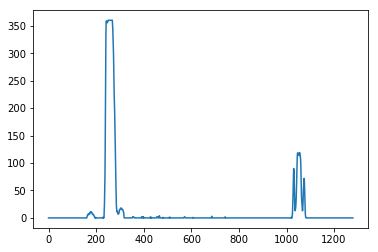

In [48]:
path = TESTIMAGES[0]
img = mpimg.imread(path)
img = undistort(img, mtx=MTX, dist=DIST)
combined_binary, _ = combinedColorGradientThreshold(img)
warped_image, M_image = perspectiveTransform(img, SRC, DST)
warped_binary, M_binary = perspectiveTransform(combined_binary, SRC, DST)
hist = histogram(warped_binary)
plt.plot(hist)